# 데이터 선정 이유 및 문제 정의

평소에 서울시 공공자전거인 따릉이를 자주 이용했는데 적자이기 때문에 신규 도입이 잠정 중단되었다는 기사를 접할 수 있었다. 다행히도 그 기사 이후 사람들의 반발이 이어져서 서울시가 내년까지 따릉이 6천대를 추가 도입하기로 했습니다. 이를 보고 어떻게 하면 따릉이를 효율적으로 배치하여 적자를 줄일 수 있을지에 대해 생각해보게 되었고, 따릉이와 관련된 데이터를 찾아 대여소별 이용횟수를 에측하는 회귀모델을 만들어 보고자 하였습니다.

#### 데이터 수집
서울 열린데이터 광장에서 제공하는 '서울특별시 공공자전거 이용정보(시간대별)'와 '공공자전거 대여소 정보' 활용

대여소에 대한 정보는 '공공자전거 대여소 정보'를 활용하고 각 대여소 별 이용횟수는 '서울특별시 공공자전거 이용정보(시간대별)'를 이용하여 구한 후 join하여 데이터를 만들어서 자치구, 위도, 경도, 거치대수, 운영방식의 특성들을 이용해 대여소별 이용횟수를 예측


# 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

가설 - 자치구, 위도, 경도, 거치대수, 운영방식의 특성들이 자전거 대여소별 이용횟수에 영향을 줄 것이다.

평가지표 - MAE

베이스라인 - 대여소별 이용횟수의 평균

In [39]:
import pandas as pd

df_2106 = pd.read_csv('2106.csv', encoding='cp949')
print(df_2106.shape)
df_2106.head() 

(2616598, 12)


,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,~10대,1,8.75,0.08,350.53,3
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,~10대,1,54.31,0.49,2110.00,14
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,~10대,1,26.30,0.18,772.25,6
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,~10대,1,27.50,0.30,1285.82,5
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,~10대,1,42.46,0.46,1985.56,21


In [40]:
df_info_2106 = pd.read_csv('위치정보2106.csv', encoding='cp949')
print(df_info_2106.shape)
df_info_2106.head()

(2467, 10)


,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,거치대수_LCD,거치대수_QR,운영방식
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,20.0,NaN,LCD
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,14.0,NaN,LCD
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,13.0,NaN,LCD
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,5.0,NaN,LCD
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,10.0,NaN,LCD


# EDA와 데이터 전처리

In [41]:
count = pd.DataFrame(df_2106.groupby(by =['대여소번호']).size()) #groupby와 size를 이용해 대여소별 이용횟수 구함
count.columns = ['대여소별_이용횟수']
count.head()

,대여소별_이용횟수
대여소번호,
3,16
5,3
10,3
102,3307
103,2879


In [42]:
train = pd.merge(df_info_2106, count, on='대여소번호', how='inner')
train.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,거치대수_LCD,거치대수_QR,운영방식,대여소별_이용횟수
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,20.0,NaN,LCD,3307
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,14.0,NaN,LCD,2879
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,13.0,NaN,LCD,1538
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,5.0,NaN,LCD,1207
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,10.0,NaN,LCD,2977


In [43]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
train['대여소별_이용횟수'].describe()

count    2456.000000
mean     1064.730049
std       815.000276
min         4.000000
25%       471.750000
50%       887.000000
75%      1438.500000
max      7003.000000
Name: 대여소별_이용횟수, dtype: float64

In [45]:
#baseline
predict = train['대여소별_이용횟수'].mean()
errors = predict - train['대여소별_이용횟수']
baseline_mean_absolute_error = errors.abs().mean()
baseline_mean_absolute_error

608.229252100823

In [46]:
train[train['경도']==0]

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,거치대수_LCD,거치대수_QR,운영방식,대여소별_이용횟수
1210,1686,온수골사거리(스타벅스앞),노원구,노원구 동일로227길 85,0.0,0.0,2018-11-02,10.0,NaN,LCD,2240


In [47]:
train = train.drop(1210)

In [48]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2, random_state=2)
test, val = train_test_split(test, test_size=0.5, random_state=2)
train.shape, test.shape, val.shape

((1964, 11), (245, 11), (246, 11))

In [49]:
def engineer(df):
    df['거치대수_LCD'] = df['거치대수_LCD'].fillna(0)
    df['거치대수_QR'] = df['거치대수_QR'].fillna(0)
    
    df['총거치대수'] = df['거치대수_LCD'] + df['거치대수_QR']
    
    df = df.drop(['보관소(대여소)명','상세주소','설치시기'], axis=1)
    df = df.set_index('대여소번호')
    
    return df
    
train = engineer(train)
val = engineer(val)
test = engineer(test)
train.head()

,자치구,위도,경도,거치대수_LCD,거치대수_QR,운영방식,대여소별_이용횟수,총거치대수
대여소번호,,,,,,,,
106,마포구,37.548645,126.912826,10.0,0.0,LCD,2977,10.0
1063,강동구,37.556664,127.142738,0.0,15.0,QR,402,15.0
4319,서초구,37.479012,127.041443,0.0,10.0,QR,129,10.0
1388,성북구,37.590881,127.011703,0.0,10.0,QR,656,10.0
1079,강동구,37.561844,127.170845,0.0,15.0,QR,318,15.0


In [50]:
target = '대여소별_이용횟수'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [51]:
X_train.head()

,자치구,위도,경도,거치대수_LCD,거치대수_QR,운영방식,총거치대수
대여소번호,,,,,,,
106,마포구,37.548645,126.912826,10.0,0.0,LCD,10.0
1063,강동구,37.556664,127.142738,0.0,15.0,QR,15.0
4319,서초구,37.479012,127.041443,0.0,10.0,QR,10.0
1388,성북구,37.590881,127.011703,0.0,10.0,QR,10.0
1079,강동구,37.561844,127.170845,0.0,15.0,QR,15.0


1) Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?
    
    df_2106의 특성들을 제거하고 groupby를 이용하여 대여소별 이용횟수만을 가져옴으로써 데이터 누수를 방지할 수 있었다.

2) 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

    대여소의 위치, 거치대수, 운영방식을 가지고 대여소별 이용횟수를 예측하려고 할 때 사용할 수 있다. 한계점은 train 데이터의 수가 적다는 한계가 있다.

# 머신러닝 방식 적용 및 교차검증

Ridge - One-Hot Encoding

In [14]:
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

pipe = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=5),
    Ridge(alpha=1.0)
)

k = 20

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)
-scores.max()

MAE (20 folds): [507.43627194 721.01187901 559.8901984  574.59807053 651.44528023
 562.35130334 545.30066307 538.74343745 532.52821497 597.23723581
 536.89733741 585.10778398 566.34501543 659.89906131 608.34437978
 558.58452371 543.05969037 526.39491469 580.8823384  546.59829389]


507.43627194370515

Ridge - Ordinal Encoding

In [15]:
from category_encoders import OrdinalEncoder

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=5),
    Ridge(alpha=1.0)
)

k = 20

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)
-scores.max()

MAE (20 folds): [503.18020582 733.51261937 551.9366742  582.97066279 684.6913878
 589.07929303 572.00206416 557.13722733 547.22066284 599.20811463
 542.65053819 586.83027054 579.09990135 657.18634658 611.77797845
 578.52127265 522.26360715 552.82988923 571.74881721 565.61061214]


503.18020582121403

Ridge - Target Encoding

In [16]:
from category_encoders import TargetEncoder

pibpe = make_pipeline(
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=5),
    Ridge(alpha=1.0)
)

k = 20

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)
-scores.max()

MAE (20 folds): [503.18020582 733.51261937 551.9366742  582.97066279 684.6913878
 589.07929303 572.00206416 557.13722733 547.22066284 599.20811463
 542.65053819 586.83027054 579.09990135 657.18634658 611.77797845
 578.52127265 522.26360715 552.82988923 571.74881721 565.61061214]


503.18020582121403

Random Forest - One-Hot Encoding

In [17]:
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 20

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)
-scores.max()

MAE for 20 folds: [414.5478677  655.93066749 480.02695581 574.44986918 567.89432258
 517.38624725 438.17569716 444.35867843 475.98280075 498.53270779
 457.37673243 485.34312282 459.12977494 565.93759986 488.71328131
 467.40067836 451.33184963 454.30717671 530.1423342  473.72733287]


414.5478677044603

Random Forest - Ordinal Encoding

In [18]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 20

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)
-scores.max()

MAE for 20 folds: [423.64300294 660.21749119 482.12719252 582.29132038 559.85491967
 532.75142112 445.08422271 443.06426589 480.33151529 505.16896952
 452.73248242 497.49798953 477.5575485  560.89321962 489.59308228
 478.0877011  449.02523445 461.02762658 526.44207666 491.31968828]


423.64300293999503

Random Forest - Target Encoding

In [19]:
pipe = make_pipeline(
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 20

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)
-scores.max()

MAE for 20 folds: [433.05794398 670.74867871 491.96986281 575.47950368 572.2712281
 522.97417999 439.50147407 473.85172506 467.0730223  492.42521454
 448.38396051 493.5571514  465.53946028 568.17444627 487.59907206
 462.31577545 482.36708117 445.45718903 510.03711603 484.28161369]


433.05794397887405

### Random Forest - Ordinal Encoding과 Random Forest - One-Hot Encoding을 한 모델의 성능이 좋으므로 이를 가지고 하이퍼파라미터 튜닝

In [20]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)
sorted(pipe.get_params().keys())

['memory',
 'ordinalencoder',
 'ordinalencoder__cols',
 'ordinalencoder__drop_invariant',
 'ordinalencoder__handle_missing',
 'ordinalencoder__handle_unknown',
 'ordinalencoder__mapping',
 'ordinalencoder__return_df',
 'ordinalencoder__verbose',
 'randomforestregressor',
 'randomforestregressor__bootstrap',
 'randomforestregressor__ccp_alpha',
 'randomforestregressor__criterion',
 'randomforestregressor__max_depth',
 'randomforestregressor__max_features',
 'randomforestregressor__max_leaf_nodes',
 'randomforestregressor__max_samples',
 'randomforestregressor__min_impurity_decrease',
 'randomforestregressor__min_impurity_split',
 'randomforestregressor__min_samples_leaf',
 'randomforestregressor__min_samples_split',
 'randomforestregressor__min_weight_fraction_leaf',
 'randomforestregressor__n_estimators',
 'randomforestregressor__n_jobs',
 'randomforestregressor__oob_score',
 'randomforestregressor__random_state',
 'randomforestregressor__verbose',
 'randomforestregressor__warm_start',

In [21]:
from sklearn.model_selection import RandomizedSearchCV

dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__random_state': [1, 2, 5, 10, 100, 1000],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'randomforestregressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=20,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'randomforestregressor__random_state': 10, 'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_depth': 80}
MAE:  489.90750565512246


In [22]:
from sklearn.metrics import mean_absolute_error

pipe = clf.best_estimator_

y_pred_val = pipe.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
print(f'검증세트 MAE: {mae_val:,.0f}')

y_pred = pipe.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: {mae_test:,.0f}')

검증세트 MAE: 538
테스트세트 MAE: 473


In [23]:
pipe

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['자치구', '운영방식'],
                                mapping=[{'col': '자치구', 'data_type': dtype('O'),
                                          'mapping': 마포구      1
영등포구     2
은평구      3
금천구      4
노원구      5
동작구      6
서초구      7
성북구      8
강동구      9
양천구     10
동대문구    11
서대문구    12
중구      13
강북구     14
관악구     15
중랑구     16
송파구     17
강남구     18
구로구     19
종로구     20
성동구     21
광진구     22
강서구     23
용산구     24
도봉구     25
NaN     -2
dtype: int64},
                                         {'col': '운영방식',
                                          'data_type': dtype('O'),
                                          'mapping': QR     1
LCD    2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=80, min_samples_leaf=4,
                                       n_estimators=800, n_jobs=-1,
                   

In [35]:
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__random_state': [1, 2, 5, 10, 100, 1000],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'randomforestregressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=20,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

Fitting 20 folds for each of 50 candidates, totalling 1000 fits
최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'randomforestregressor__random_state': 1000, 'randomforestregressor__n_estimators': 2000, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 90}
MAE:  487.4627596391953


In [36]:
from sklearn.metrics import mean_absolute_error

pipe = clf.best_estimator_

y_pred_val = pipe.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
print(f'검증세트 MAE: {mae_val:,.0f}')

y_pred = pipe.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: {mae_test:,.0f}')

검증세트 MAE: 538
테스트세트 MAE: 467


In [37]:
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['자치구', '운영방식'])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=90, min_samples_leaf=2,
                                       n_estimators=2000, n_jobs=-1,
                                       random_state=1000))])

1) 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?

    베이스라인 MAE : 608.229252100823
    모델 MAE : 472
    
    베이스라인보다 잘 나왔음을 볼 수 있다.
    
2) 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?

    파라미터 튜닝이 많이 필요하기 때문에 RandomizedSearchCV를 사용
    
3) 최종 모델에 관해 설명하세요.

    Random Forest - Ordinal Encoding를 활용한 모델을 최종 모델로 선정

# 머신러닝 모델 해석

In [26]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['자치구', '운영방식'],
                                mapping=[{'col': '자치구', 'data_type': dtype('O'),
                                          'mapping': 마포구      1
영등포구     2
은평구      3
금천구      4
노원구      5
동작구      6
서초구      7
성북구      8
강동구      9
양천구     10
동대문구    11
서대문구    12
중구      13
강북구     14
관악구     15
중랑구     16
송파구     17
강남구     18
구로구     19
종로구     20
성동구     21
광진구     22
강서구     23
용산구     24
도봉구     25
NaN     -2
dtype: int64},
                                         {'col': '운영방식',
                                          'data_type': dtype('O'),
                                          'mapping': QR     1
LCD    2
NaN   -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=2))])

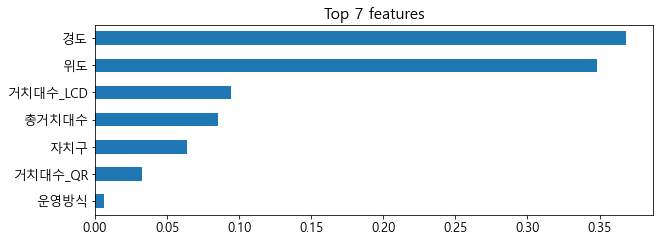

In [27]:
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X_test)

rf = pipe.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_encoded.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 7
plt.figure(figsize=(10,n/2))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 13
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='경도'>})

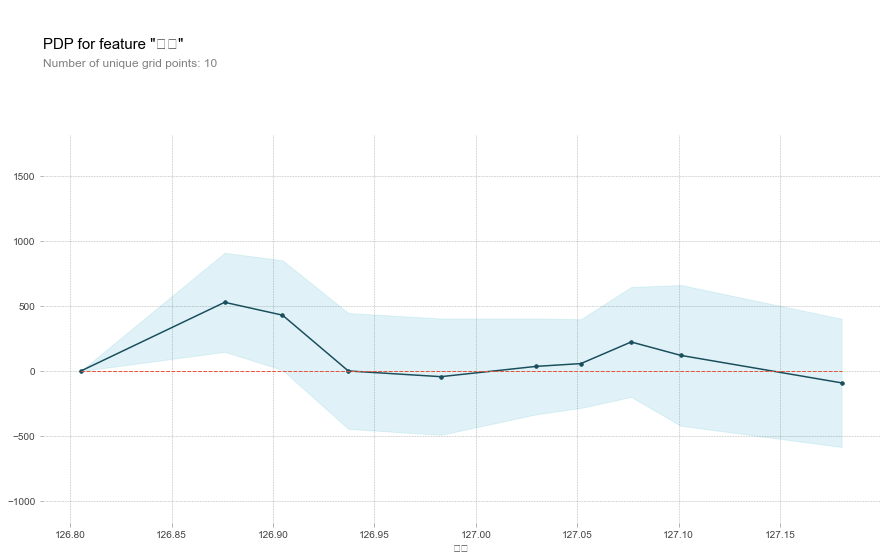

In [28]:
from pdpbox import pdp

feature = '경도'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

경도가 126.80 ~ 126.854, 126.957~127.052 에서는 우상향 그래프이므로 이 때에는 경도의 값이 커지면 대여소별 이용횟수도 많아지는 것을 알 수 있다. 이 외에는 우하향 그래프이므로 경도의 값이 커지면 대여소별 이용횟수가 적어진다는 것을 알 수 있다.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='위도'>})

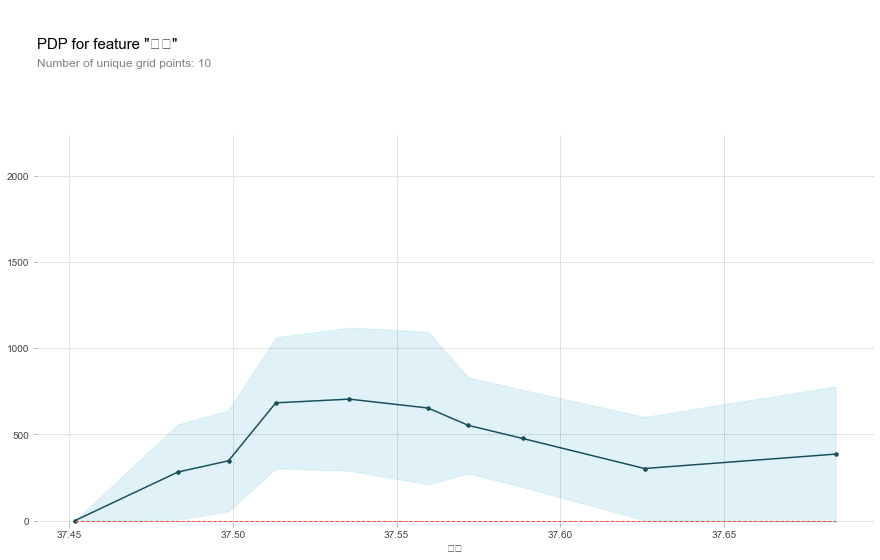

In [29]:
feature = '위도'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

위도가 37.43 ~ 37.52 에서는 우상향 그래프이므로 이 때에는 위도의 값이 커지면 대여소별 이용횟수도 많아지는 것을 알 수 있다.
위도가 37.52보다 클 때에는 37.551 ~ 37.552에서 약간 올라가긴 하지만 대부분 우하향하므로 이 때에는 위도의 값이 커지면 대여소별 이용횟수도 적어지는 것을 알 수 있다.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='거치대수_LCD'>})

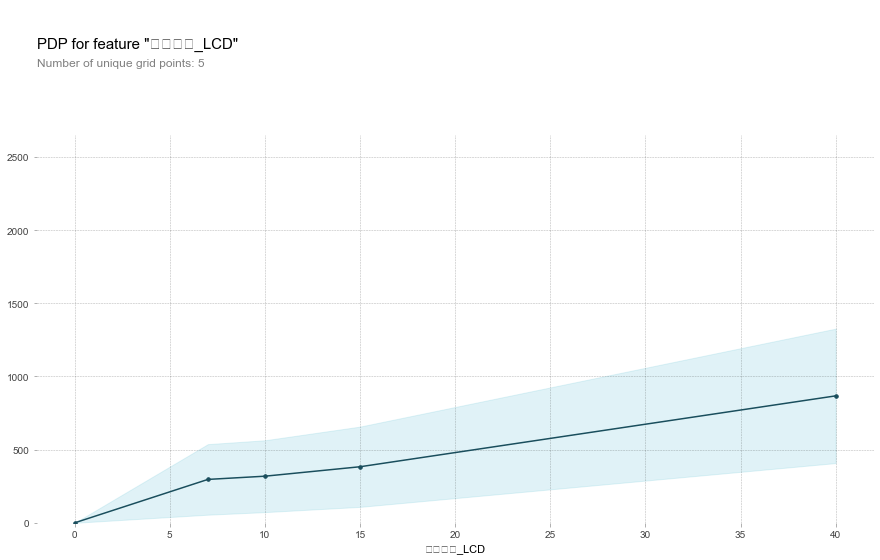

In [30]:
feature = '거치대수_LCD'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='총거치대수'>})

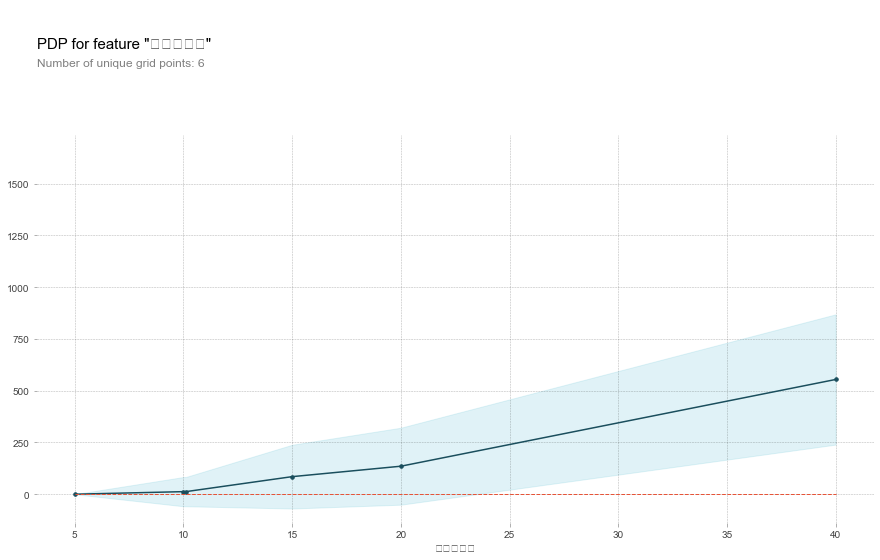

In [31]:
feature = '총거치대수'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

그래프를 통해서 거치대수_LCD, 총 거치대수는 각 값이 커질 수록 대여소별 이용횟수가 늘어난다는 것을 알 수 있다.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='자치구'>})

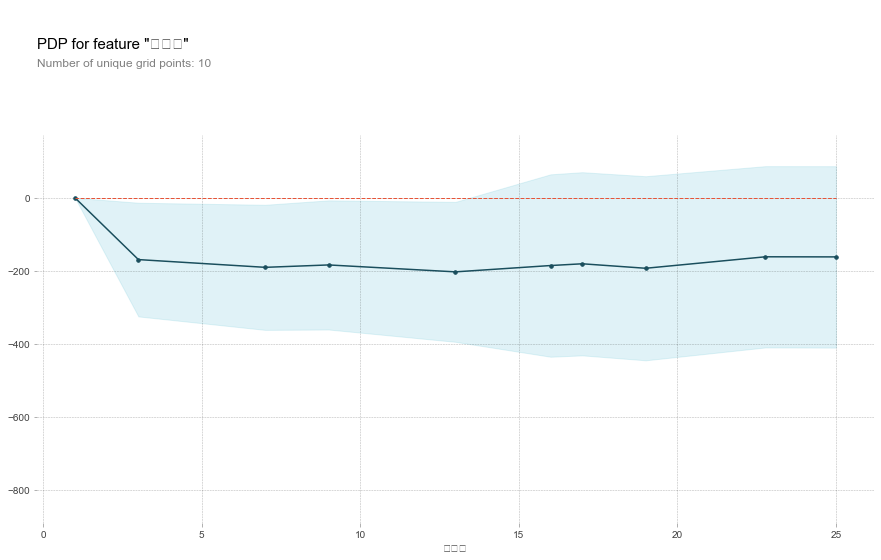

In [32]:
feature = '자치구'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

In [33]:
encoder.mapping

[{'col': '자치구',
  'mapping': 마포구      1
  영등포구     2
  은평구      3
  금천구      4
  노원구      5
  동작구      6
  서초구      7
  성북구      8
  강동구      9
  양천구     10
  동대문구    11
  서대문구    12
  중구      13
  강북구     14
  관악구     15
  중랑구     16
  송파구     17
  강남구     18
  구로구     19
  종로구     20
  성동구     21
  광진구     22
  강서구     23
  용산구     24
  도봉구     25
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': '운영방식',
  'mapping': QR     1
  LCD    2
  NaN   -2
  dtype: int64,
  'data_type': dtype('O')}]

그래프가 쭉 우하향하다가 20부터 약간 우상향하는 모습을 볼 수 있다. encoder 맵핑 결과와 같이 보면 마포구~ 동작구까지는 대여소별 이용횟수가 감소하고 동작구 ~ 광진구는 증가하는 것을 알 수 있다.

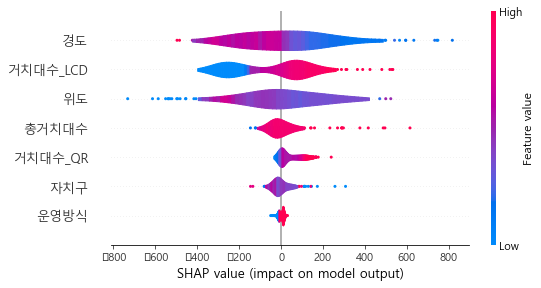

In [38]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_encoded)
shap.force_plot(explainer.expected_value, shap_values, X_encoded)


shap_values = explainer.shap_values(X_encoded)
shap.summary_plot(shap_values, X_encoded, plot_type="violin")

바이올린 그래프의 붉은 부분은 특성의 값이 크고 파란 부분은 특성의 값이 작은 부분이다. 
경도는 분산이 가장 크고 양으로도, 음으로도 큰 영향을 주고 있지만 특히, 양으로 큰 영향을 주고 있다.
거치대수_LCD, 위도도 분산이 큰 편이고 양과 음 모두 큰 영향을 주고 있다.
다른 특성들은 상대적으로 분산이 작고, shap value에 큰 영향을 주지 않는다. 

대여소가 있는 지역에 대한 유동인구 데이터가 있으면 더 좋은 모델을 만들 수 있을 것 같다.